In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import helpers
import plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
data_folder = 'data/csv/'
data_files = [mice + ".smo.csv" for mice in helpers.mice_breeds["bxd_101"]][0]

print(data_files)

days = [0]
window_sizes = [2, 5, 10, 50, 100]
window_features = ["EEGv", "EMGv"]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
seed = 13

10101.smo.csv


In [15]:
# train and test on same mice
df = features.clean_data(data_folder, data_files, days, window_sizes, window_features, dropBins, useRaw)
x_train, x_test, y_train, y_test, le = features.split_encode_scale_data(df, useRaw, test_size, seed, cat_matrix)

Dropping 401 bins
Balancing classes to 816 samples per class (total: 2448)


# Neural Network

In [26]:
def baseline_model(input_dim, num_classes, lr=0.0001):
    model = Sequential()
    model.add(Dense(3, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 135       
                                                                 
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

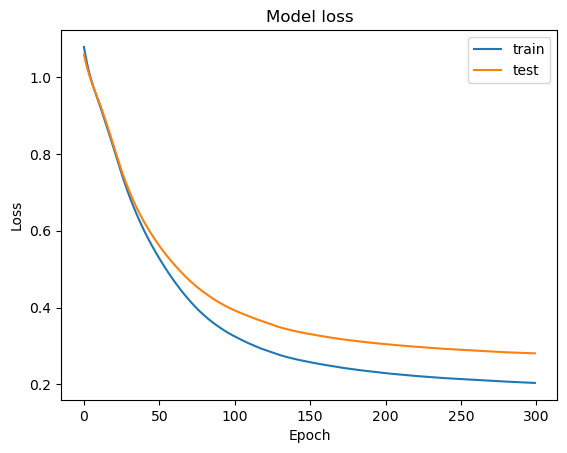

In [33]:
model = baseline_model(x_train.shape[1], le.classes_.size)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=300,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_loss(history.history)

23/23 [==============================] - 0s 818us/step
[[228  17   8]
 [ 28 223   4]
 [  8  14 205]]
              precision    recall  f1-score   support

           n       0.86      0.90      0.88       253
           r       0.88      0.87      0.88       255
           w       0.94      0.90      0.92       227

    accuracy                           0.89       735
   macro avg       0.90      0.89      0.89       735
weighted avg       0.89      0.89      0.89       735



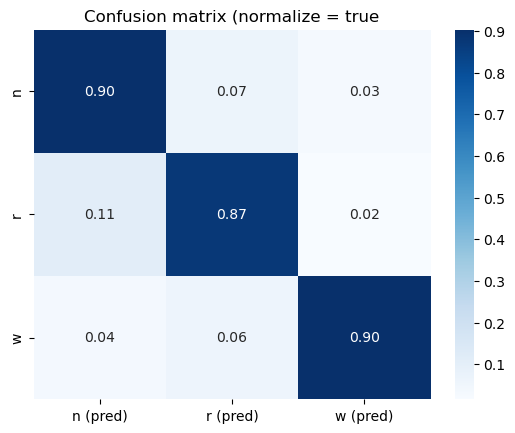

In [34]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[236  13   4]
 [ 21 232   2]
 [ 15  10 202]]
              precision    recall  f1-score   support

           n       0.87      0.93      0.90       253
           r       0.91      0.91      0.91       255
           w       0.97      0.89      0.93       227

    accuracy                           0.91       735
   macro avg       0.92      0.91      0.91       735
weighted avg       0.91      0.91      0.91       735



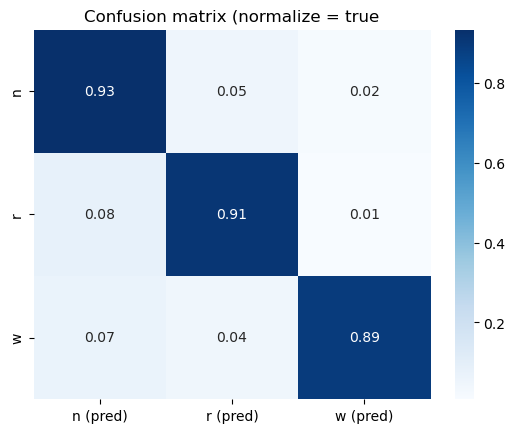

"Score": 0.8965986394557823


In [35]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')